In [1]:
import numpy as np
import os
import service.train as train_service

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# define base data, label store path
base_data_path = train_service.old_data_path

In [10]:
with open(f'{base_data_path}/labels.txt', 'r') as f:
    lines = f.readlines()
    # actions = [line.strip().split()[0] for line in lines]
    # labels = [line.strip().split()[1] for line in lines]
    actions, labels = zip(*[line.strip().split() for line in lines])

# 라벨 추가 작업 수행
gesture_data = []
for action, label in zip(actions, labels):
    seq_data = np.load(f'{base_data_path}/seq_{action}.npy')
    label_data = np.full((seq_data.shape[0], seq_data.shape[1], 1), label) # 라벨 추가
    data_with_label = np.concatenate([seq_data, label_data], axis=-1) # 라벨 추가된 데이터
    gesture_data.append(data_with_label)

data = np.concatenate(gesture_data, axis=0)
data.shape

(3701, 30, 78)

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

x_data.shape, labels.shape

((3701, 30, 77), (3701,))

In [5]:
from keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(3701, 6)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2022)

x_train.shape, y_train.shape

((3330, 30, 77), (3330, 6))

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
model = Sequential([
    GRU(64, activation='tanh', input_shape=x_train.shape[1:3]),
    Dense(16, activation='tanh'),
    Dropout(0.5),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                27456     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 28,598
Trainable params: 28,598
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define the callbacks
callbacks = [
    ModelCheckpoint('models/base_model1.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=30, verbose=1, mode='auto'),
]

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=128,
    callbacks=callbacks
)

Epoch 1/200
25/27 [==========================>...] - ETA: 0s - loss: 1.8044 - acc: 0.2834
Epoch 1: val_acc improved from -inf to 0.65768, saving model to models\base_model1.h5
27/27 [==============================] - 2s 32ms/step - loss: 1.7998 - acc: 0.2823 - val_loss: 1.2958 - val_acc: 0.6577 - lr: 0.0010
Epoch 2/200
27/27 [==============================] - ETA: 0s - loss: 1.3396 - acc: 0.5069
Epoch 2: val_acc improved from 0.65768 to 0.83019, saving model to models\base_model1.h5
27/27 [==============================] - 1s 20ms/step - loss: 1.3396 - acc: 0.5069 - val_loss: 1.0198 - val_acc: 0.8302 - lr: 0.0010
Epoch 3/200
25/27 [==========================>...] - ETA: 0s - loss: 1.0175 - acc: 0.7209
Epoch 3: val_acc improved from 0.83019 to 0.91105, saving model to models\base_model1.h5
27/27 [==============================] - 0s 19ms/step - loss: 1.0138 - acc: 0.7228 - val_loss: 0.7352 - val_acc: 0.9111 - lr: 0.0010
Epoch 4/200
26/27 [===========================>..] - ETA: 0s - loss

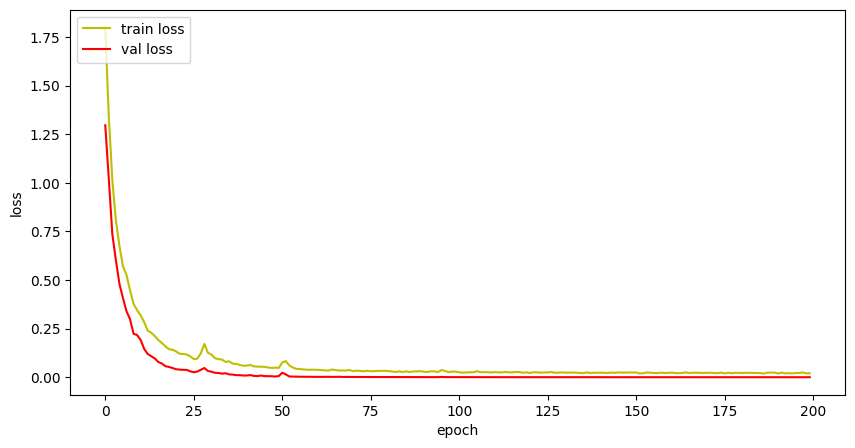

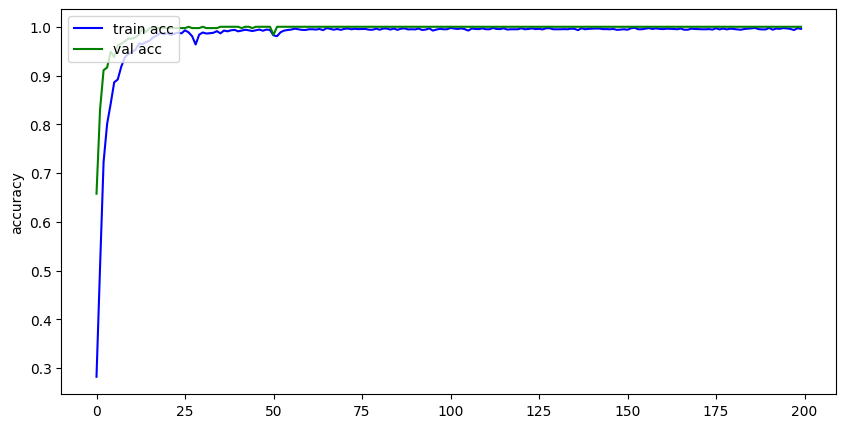

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10, 5))

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

fig, acc_ax = plt.subplots(figsize=(10, 5))
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()